In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from data.bt_dataset import BrainTumorDataset
from model2 import BrainTumorCNN
from torch.utils.data import DataLoader
import torchvision
import torch
import os
import cv2
from data.preprocessing import *
from train import train
from evaluate import evaluate
from torch.optim.lr_scheduler import StepLR

In [9]:
if torch.cuda.is_available():
    print("Working on: GPU")
    device = 'cuda'
else:
    print("Working on: CPU")
    device = 'cpu'

Working on: GPU


### Defining constants:

In [10]:
IMAGE_SIZE = 256
NUM_OF_CLASSES = 4
train_batch_size = test_batch_size = 12
dataset_path = os.path.join(os.getcwd(), 'data')

### Preprocessing:

In [11]:
# Resizing the images and sharpening them:
preprocessing_ops = [resize([IMAGE_SIZE, IMAGE_SIZE]), sharpen()]

### Defining the dataset:

In [12]:
# Defining the Dataset object:
dataset = BrainTumorDataset(dataset_path=dataset_path, preprocessing=preprocessing_ops)

# Defining the DataLoader object:
train_loader = DataLoader(dataset, batch_size=train_batch_size)

### Model specifications:

In [13]:
model = BrainTumorCNN(number_of_classes=NUM_OF_CLASSES, image_size=IMAGE_SIZE)

parameters = model.parameters()
learning_rate = 1e-4
weight_decay = 2e-5
momentum = 0.9

# Getting the class weights to apply weighted loss:
class_weights = torch.tensor(dataset.class_weights).float().to(device)
criterion = torch.nn.CrossEntropyLoss(weight=class_weights).to(device)
optimizer = torch.optim.SGD(parameters, lr=learning_rate, momentum=momentum, weight_decay=weight_decay)
# optimizer = torch.optim.SGD(parameters, lr=learning_rate, momentum=momentum)
# optimizer = torch.optim.Adam(parameters, lr=learning_rate, weight_decay=weight_decay)
# optimizer = torch.optim.Adam(parameters, lr=learning_rate)

In [14]:
scheduler = StepLR(optimizer, step_size=10, gamma=1.2)

### Training the model

In [15]:
# Defining the Dataset object:
dataset = BrainTumorDataset(dataset_path=dataset_path, preprocessing=preprocessing_ops, test=True)

# Defining the DataLoader object:
test_loader = DataLoader(dataset, batch_size=train_batch_size)

In [16]:
epochs = 50

In [17]:
total_loss, epoch_times, accuracies_train, accuracies_test = train(model=model, train_loader=train_loader,
                                                                   test_loader=test_loader, optimizer=optimizer,
                                                                   criterion=criterion, epochs=epochs, scheduler=scheduler)
# total_loss, epoch_times, accuracies_train, accuracies_test = train(model=model, train_loader=train_loader,
#                                                                    test_loader=test_loader, optimizer=optimizer,
#                                                                    criterion=criterion, epochs=epochs)

100%|██████████| 240/240 [00:13<00:00, 17.48it/s]


Learning rate: 1e-05
Epoch: 0 | Loss: 224.88
Epoch: 0 took: 25.65 seconds


100%|██████████| 240/240 [00:10<00:00, 22.27it/s]


Learning rate: 1e-05
Epoch: 1 | Loss: 340.03
Epoch: 1 took: 22.98 seconds


100%|██████████| 240/240 [00:11<00:00, 21.16it/s]


Learning rate: 1e-05
Epoch: 2 | Loss: 335.75
Epoch: 2 took: 23.15 seconds


100%|██████████| 240/240 [00:11<00:00, 21.78it/s]


Learning rate: 1e-05
Epoch: 3 | Loss: 333.59
Epoch: 3 took: 23.77 seconds


100%|██████████| 240/240 [00:11<00:00, 21.59it/s]


Learning rate: 1e-05
Epoch: 4 | Loss: 332.16
Epoch: 4 took: 22.93 seconds


100%|██████████| 240/240 [00:10<00:00, 22.03it/s]


Learning rate: 1.2e-05
Epoch: 5 | Loss: 331.76
Epoch: 5 took: 22.71 seconds


100%|██████████| 240/240 [00:10<00:00, 21.93it/s]


Learning rate: 1.2e-05
Epoch: 6 | Loss: 331.11
Epoch: 6 took: 22.66 seconds


100%|██████████| 240/240 [00:10<00:00, 21.98it/s]


Learning rate: 1.2e-05
Epoch: 7 | Loss: 330.25
Epoch: 7 took: 22.91 seconds


100%|██████████| 240/240 [00:11<00:00, 21.77it/s]


Learning rate: 1.2e-05
Epoch: 8 | Loss: 329.29
Epoch: 8 took: 22.77 seconds


100%|██████████| 240/240 [00:10<00:00, 22.18it/s]


Learning rate: 1.2e-05
Epoch: 9 | Loss: 328.29
Epoch: 9 took: 23.01 seconds


100%|██████████| 240/240 [00:11<00:00, 21.68it/s]


Learning rate: 1.44e-05
Epoch: 10 | Loss: 327.84
Epoch: 10 took: 22.95 seconds


100%|██████████| 240/240 [00:10<00:00, 21.90it/s]


Learning rate: 1.44e-05
Epoch: 11 | Loss: 327.28
Epoch: 11 took: 22.76 seconds


100%|██████████| 240/240 [00:10<00:00, 22.10it/s]


Learning rate: 1.44e-05
Epoch: 12 | Loss: 326.31
Epoch: 12 took: 22.65 seconds


100%|██████████| 240/240 [00:10<00:00, 22.03it/s]


Learning rate: 1.44e-05
Epoch: 13 | Loss: 325.16
Epoch: 13 took: 23.18 seconds


100%|██████████| 240/240 [00:11<00:00, 21.79it/s]


Learning rate: 1.44e-05
Epoch: 14 | Loss: 323.94
Epoch: 14 took: 22.66 seconds


100%|██████████| 240/240 [00:10<00:00, 22.22it/s]


Learning rate: 1.7279999999999997e-05
Epoch: 15 | Loss: 322.94
Epoch: 15 took: 22.47 seconds


100%|██████████| 240/240 [00:10<00:00, 22.20it/s]


Learning rate: 1.7279999999999997e-05
Epoch: 16 | Loss: 322.38
Epoch: 16 took: 22.51 seconds


100%|██████████| 240/240 [00:10<00:00, 22.01it/s]


Learning rate: 1.7279999999999997e-05
Epoch: 17 | Loss: 321.19
Epoch: 17 took: 22.61 seconds


100%|██████████| 240/240 [00:10<00:00, 21.98it/s]


Learning rate: 1.7279999999999997e-05
Epoch: 18 | Loss: 319.76
Epoch: 18 took: 25.99 seconds


100%|██████████| 240/240 [00:11<00:00, 21.64it/s]


Learning rate: 1.7279999999999997e-05
Epoch: 19 | Loss: 318.25
Epoch: 19 took: 22.89 seconds


100%|██████████| 240/240 [00:10<00:00, 22.10it/s]


Learning rate: 2.0735999999999996e-05
Epoch: 20 | Loss: 316.38
Epoch: 20 took: 25.98 seconds


100%|██████████| 240/240 [00:11<00:00, 20.48it/s]


Learning rate: 2.0735999999999996e-05
Epoch: 21 | Loss: 316.13
Epoch: 21 took: 23.48 seconds


100%|██████████| 240/240 [00:10<00:00, 22.20it/s]


Learning rate: 2.0735999999999996e-05
Epoch: 22 | Loss: 314.78
Epoch: 22 took: 25.77 seconds


100%|██████████| 240/240 [00:11<00:00, 21.82it/s]


Learning rate: 2.0735999999999996e-05
Epoch: 23 | Loss: 313.11
Epoch: 23 took: 22.75 seconds


100%|██████████| 240/240 [00:11<00:00, 21.72it/s]


Learning rate: 2.0735999999999996e-05
Epoch: 24 | Loss: 311.34
Epoch: 24 took: 26.00 seconds


100%|██████████| 240/240 [00:11<00:00, 21.57it/s]


Learning rate: 2.4883199999999996e-05
Epoch: 25 | Loss: 308.53
Epoch: 25 took: 22.96 seconds


100%|██████████| 240/240 [00:10<00:00, 22.00it/s]


Learning rate: 2.4883199999999996e-05
Epoch: 26 | Loss: 308.86
Epoch: 26 took: 25.66 seconds


100%|██████████| 240/240 [00:10<00:00, 21.99it/s]


Learning rate: 2.4883199999999996e-05
Epoch: 27 | Loss: 307.29
Epoch: 27 took: 22.56 seconds


100%|██████████| 240/240 [00:10<00:00, 21.85it/s]


Learning rate: 2.4883199999999996e-05
Epoch: 28 | Loss: 305.38
Epoch: 28 took: 23.34 seconds


100%|██████████| 240/240 [00:11<00:00, 21.77it/s]


Learning rate: 2.4883199999999996e-05
Epoch: 29 | Loss: 303.26
Epoch: 29 took: 22.69 seconds


100%|██████████| 240/240 [00:10<00:00, 22.02it/s]


Learning rate: 2.9859839999999994e-05
Epoch: 30 | Loss: 299.67
Epoch: 30 took: 22.75 seconds


100%|██████████| 240/240 [00:11<00:00, 20.80it/s]


Learning rate: 2.9859839999999994e-05
Epoch: 31 | Loss: 299.84
Epoch: 31 took: 23.19 seconds


100%|██████████| 240/240 [00:10<00:00, 21.90it/s]


Learning rate: 2.9859839999999994e-05
Epoch: 32 | Loss: 297.77
Epoch: 32 took: 23.49 seconds


100%|██████████| 240/240 [00:10<00:00, 21.84it/s]


Learning rate: 2.9859839999999994e-05
Epoch: 33 | Loss: 295.23
Epoch: 33 took: 22.65 seconds


100%|██████████| 240/240 [00:10<00:00, 21.99it/s]


Learning rate: 2.9859839999999994e-05
Epoch: 34 | Loss: 292.46
Epoch: 34 took: 22.67 seconds


100%|██████████| 240/240 [00:10<00:00, 22.11it/s]


Learning rate: 3.583180799999999e-05
Epoch: 35 | Loss: 287.93
Epoch: 35 took: 22.48 seconds


100%|██████████| 240/240 [00:10<00:00, 22.08it/s]


Learning rate: 3.583180799999999e-05
Epoch: 36 | Loss: 287.61
Epoch: 36 took: 23.11 seconds


100%|██████████| 240/240 [00:10<00:00, 21.83it/s]


Learning rate: 3.583180799999999e-05
Epoch: 37 | Loss: 285.03
Epoch: 37 took: 22.60 seconds


100%|██████████| 240/240 [00:10<00:00, 21.88it/s]


Learning rate: 3.583180799999999e-05
Epoch: 38 | Loss: 282.20
Epoch: 38 took: 22.75 seconds


100%|██████████| 240/240 [00:11<00:00, 21.77it/s]


Learning rate: 3.583180799999999e-05
Epoch: 39 | Loss: 279.41
Epoch: 39 took: 22.67 seconds


100%|██████████| 240/240 [00:10<00:00, 22.02it/s]


Learning rate: 4.299816959999999e-05
Epoch: 40 | Loss: 274.63
Epoch: 40 took: 22.51 seconds


100%|██████████| 240/240 [00:10<00:00, 21.99it/s]


Learning rate: 4.299816959999999e-05
Epoch: 41 | Loss: 275.58
Epoch: 41 took: 22.52 seconds


100%|██████████| 240/240 [00:10<00:00, 22.08it/s]


Learning rate: 4.299816959999999e-05
Epoch: 42 | Loss: 274.27
Epoch: 42 took: 23.14 seconds


100%|██████████| 240/240 [00:10<00:00, 22.10it/s]


Learning rate: 4.299816959999999e-05
Epoch: 43 | Loss: 272.37
Epoch: 43 took: 22.57 seconds


100%|██████████| 240/240 [00:10<00:00, 21.83it/s]


Learning rate: 4.299816959999999e-05
Epoch: 44 | Loss: 270.04
Epoch: 44 took: 23.39 seconds


100%|██████████| 240/240 [00:11<00:00, 21.69it/s]


Learning rate: 5.159780351999999e-05
Epoch: 45 | Loss: 264.95
Epoch: 45 took: 22.71 seconds


100%|██████████| 240/240 [00:10<00:00, 22.10it/s]


Learning rate: 5.159780351999999e-05
Epoch: 46 | Loss: 266.31
Epoch: 46 took: 23.29 seconds


100%|██████████| 240/240 [00:11<00:00, 21.77it/s]


Learning rate: 5.159780351999999e-05
Epoch: 47 | Loss: 264.71
Epoch: 47 took: 22.77 seconds


100%|██████████| 240/240 [00:10<00:00, 22.19it/s]


Learning rate: 5.159780351999999e-05
Epoch: 48 | Loss: 262.40
Epoch: 48 took: 22.66 seconds


100%|██████████| 240/240 [00:10<00:00, 21.90it/s]


Learning rate: 5.159780351999999e-05
Epoch: 49 | Loss: 259.57
Epoch: 49 took: 22.67 seconds


### Plotting the loss:

In [18]:
import matplotlib.pyplot as plt

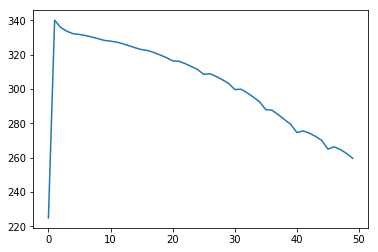

In [19]:
plt.plot(total_loss)
plt.show()

### Plotting train and test accuracies:

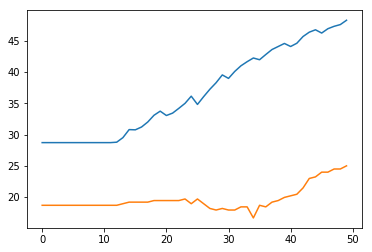

In [20]:
plt.plot(accuracies_train)
plt.plot(accuracies_test)
plt.show()

### Evaluating the model:

In [21]:
accuracy = evaluate(model=model, test_loader=test_loader)

In [22]:
print(f'Test Accuracy: {accuracy:.2f}%')

Test Accuracy: 25.00%


In [23]:
accuracy = evaluate(model=model, test_loader=train_loader)

In [24]:
print(f'Train Accuracy: {accuracy:.2f}%')

Train Accuracy: 48.30%
